In [27]:
import gpytorch
import torch
import numpy as np

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood

from gpytorch.constraints import Positive

import matplotlib.pyplot as plt

In [100]:
class NewCustomSincGPKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True
    
        # We will register the parameter when initializing the kernel
    def __init__(self, length_prior=None, lengths_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
            name='raw_lengths', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 2, 1))
        )
        print('SETUP: ', (*self.batch_shape, 2, 1))
        
        # set the parameter constraint to be positive, when nothing is specified
        lengths_constraint = lengths_constraint or Positive()

        # register the constraint
        self.register_constraint("raw_lengths", lengths_constraint)

        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        if length_prior is not None:
            self.register_prior(
                "lengths_prior",
                length_prior,
                lambda m: m.lengths,
                lambda m, v : m._set_lengths(v),
            )
            

    # now set up the 'actual' paramter
    @property
    def lengths(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_lengths_constraint.transform(self.raw_lengths)
    
    @lengths.setter
    def lengths(self, value):
        return self._set_length_1(value)
    
    def _set_lengths(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengths)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length_1=self.raw_lengths_constraint.inverse_transform(value))
        
        
    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        x1 = x1.div(self.lengths[0])
        x2 = x2.div(self.lengths[1])
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20).to(x1))
        K = torch.sin(diff).div(diff)
        print(x1.shape, x2.shape, K.shape, type(K))
        print('kernel: ', K)

        return gpytorch.lazify(K)

In [81]:
class CustomSincGPKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True
    
        # We will register the parameter when initializing the kernel
    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
            name='raw_length_1', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        self.register_parameter(
            name='raw_length_2', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        #print('SETUP: ', (*self.batch_shape, 1, 1))
        
        # set the parameter constraint to be positive, when nothing is specified
        length_constraint = length_constraint or Positive()

        # register the constraint
        self.register_constraint("raw_length_1", length_constraint)
        self.register_constraint("raw_length_2", length_constraint)

        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        if length_prior is not None:
            self.register_prior(
                "length_prior_1",
                length_prior,
                lambda m: m.length_1,
                lambda m, v : m._set_length(v),
            )
            
        if length_prior is not None:
            self.register_prior(
                "length_prior_2",
                length_prior,
                lambda m: m.length_2,
                lambda m, v : m._set_length(v),
            )
            

    # now set up the 'actual' paramter
    @property
    def length_1(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_length_1_constraint.transform(self.raw_length_1)
    @property
    def length_2(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_length_2_constraint.transform(self.raw_length_2)
    
    
    @length_1.setter
    def length_1(self, value):
        return self._set_length_1(value)
    @length_2.setter
    def length_2(self, value):
        return self._set_length_2(value)
    
    def _set_length_1(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length_1)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length_1=self.raw_length_constraint.inverse_transform(value))
    def _set_length_2(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length_2)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length_2=self.raw_length_constraint.inverse_transform(value))
        
        
    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        x1 = x1.div(self.length_1)
        x2 = x2.div(self.length_2)
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20).to(x1))
        K = torch.sin(diff).div(diff)
        print(x1.shape, x2.shape, K.shape, type(K))
        print('kernel: ', K)

        return gpytorch.lazify(K)

In [44]:
class SincGPKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True
    
        # We will register the parameter when initializing the kernel
    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
            name='raw_length', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        length_constraint = length_constraint or Positive()

        # register the constraint
        self.register_constraint("raw_length", length_constraint)

        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v : m._set_length(v),
            )

    # now set up the 'actual' paramter
    @property
    def length(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_length_constraint.transform(self.raw_length)
    @length.setter
    def length(self, value):
        return self._set_length(value)
    
    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))
        
        
    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        x1 = x1.div(self.length)
        x2 = x2.div(self.length)
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20).to(x1))
        K = torch.sin(diff).div(diff)
        print(x1.shape, x2.shape, K.shape, type(K))
        print('kernel: ', K)

        return gpytorch.lazify(K)

In [37]:
class CustomGPModel(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y, likelihood, covar_module):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = covar_module
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [98]:
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        for param_name, param in model.named_parameters():
            print(param_name, param.shape)
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        #print(list(model.named_parameters()))



def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

def plot(observed_pred, test_x=torch.linspace(0, 1, 51)):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [33]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * np.sqrt(0.04)

SETUP:  (2, 1)
likelihood.noise_covar.raw_noise torch.Size([1])
mean_module.constant torch.Size([1])
covar_module.raw_lengths torch.Size([2, 1])
likelihood.noise_covar.raw_noise torch.Size([1])
mean_module.constant torch.Size([1])
covar_module.raw_lengths torch.Size([2, 1])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 100]) <class 'torch.Tensor'>
kernel:  tensor([[1.0000, 1.0000, 0.9999,  ..., 0.6987, 0.6931, 0.6875],
        [1.0000, 1.0000, 1.0000,  ..., 0.7043, 0.6987, 0.6931],
        [0.9999, 1.0000, 1.0000,  ..., 0.7098, 0.7043, 0.6987],
        ...,
        [0.6987, 0.7043, 0.7098,  ..., 1.0000, 1.0000, 0.9999],
        [0.6931, 0.6987, 0.7043,  ..., 1.0000, 1.0000, 1.0000],
        [0.6875, 0.6931, 0.6987,  ..., 0.9999, 1.0000, 1.0000]],
       grad_fn=<DivBackward0>)
likelihood.noise_covar.raw_noise torch.Size([1])
mean_module.constant torch.Size([1])
covar_module.raw_lengths torch.Size([2, 1])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 100]) <cla

likelihood.noise_covar.raw_noise torch.Size([1])
mean_module.constant torch.Size([1])
covar_module.raw_lengths torch.Size([2, 1])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 100]) <class 'torch.Tensor'>
kernel:  tensor([[ 1.0000,  0.9980,  0.9921,  ..., -0.0866, -0.0893, -0.0908],
        [ 0.9980,  1.0000,  0.9980,  ..., -0.0828, -0.0866, -0.0893],
        [ 0.9921,  0.9980,  1.0000,  ..., -0.0779, -0.0828, -0.0866],
        ...,
        [-0.0866, -0.0828, -0.0779,  ...,  1.0000,  0.9980,  0.9920],
        [-0.0893, -0.0866, -0.0828,  ...,  0.9980,  1.0000,  0.9980],
        [-0.0908, -0.0893, -0.0866,  ...,  0.9921,  0.9980,  1.0000]],
       grad_fn=<DivBackward0>)
likelihood.noise_covar.raw_noise torch.Size([1])
mean_module.constant torch.Size([1])
covar_module.raw_lengths torch.Size([2, 1])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 100]) <class 'torch.Tensor'>
kernel:  tensor([[ 1.0000,  0.9981,  0.9924,  ..., -0.0793, -0.0838, -0.0873],
        [ 0

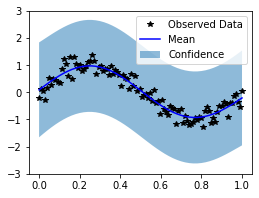

In [101]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = CustomGPModel(train_x, train_y, likelihood, SincGPKernel())
#model = CustomGPModel(train_x, train_y, likelihood, CustomSincGPKernel())
model = CustomGPModel(train_x, train_y, likelihood, NewCustomSincGPKernel())

for param_name, param in model.named_parameters():
    print(param_name, param.shape)
# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

In [13]:
# initialize the new model
model = CustomGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

NameError: name 'likelihood' is not defined